In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os


In [2]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [
            f for f in os.listdir(root_dir) 
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [3]:
import zipfile

zip_path = 'F:/computer vision/Eyes.zip'
extract_to = 'F:/computer vision/Eyes'

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extracted successfully.")
else:
    print("Already extracted.")


Already extracted.


In [4]:
import os

path = r'F:/computer vision/Eyes'
files = os.listdir(path)
print("All files:", files)

image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))]
print("Image files:", image_files)
print("Number of image files:", len(image_files))


All files: ['Dataset']
Image files: []
Number of image files: 0


In [5]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = []

        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(root, f))

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


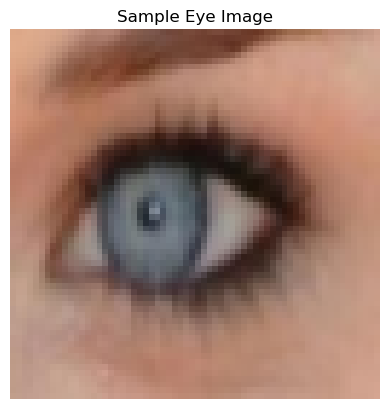

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = MyDataset(r'F:/computer vision/Eyes', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualize a sample
image = dataset[0]
plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Sample Eye Image")
plt.axis('off')
plt.show()


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64*64*3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 3, 64, 64)


In [9]:
discriminator = Discriminator()
generator = Generator()

lr = 0.0002
loss_fn = nn.BCELoss()
optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
optim_G = torch.optim.Adam(generator.parameters(), lr=lr)


In [10]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

for epoch in range(num_epochs):
    for real_imgs in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        outputs_real = discriminator(real_imgs)
        loss_real = loss_fn(outputs_real, real_labels)

        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs.detach())
        loss_fake = loss_fn(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optim_D.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_imgs)
        loss_G = loss_fn(outputs, real_labels)
        loss_G.backward()
        optim_G.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")




Epoch 0 | Loss D: 0.1574 | Loss G: 2.6114
Epoch 10 | Loss D: 0.0158 | Loss G: 9.9476
Epoch 20 | Loss D: 0.3309 | Loss G: 2.5738
Epoch 30 | Loss D: 0.5164 | Loss G: 1.4817
Epoch 40 | Loss D: 1.0445 | Loss G: 4.6481
Epoch 50 | Loss D: 0.1544 | Loss G: 3.3554
Epoch 60 | Loss D: 0.3002 | Loss G: 3.9571
Epoch 70 | Loss D: 0.2367 | Loss G: 3.0367
Epoch 80 | Loss D: 0.3908 | Loss G: 6.7496
Epoch 90 | Loss D: 0.1527 | Loss G: 4.1744


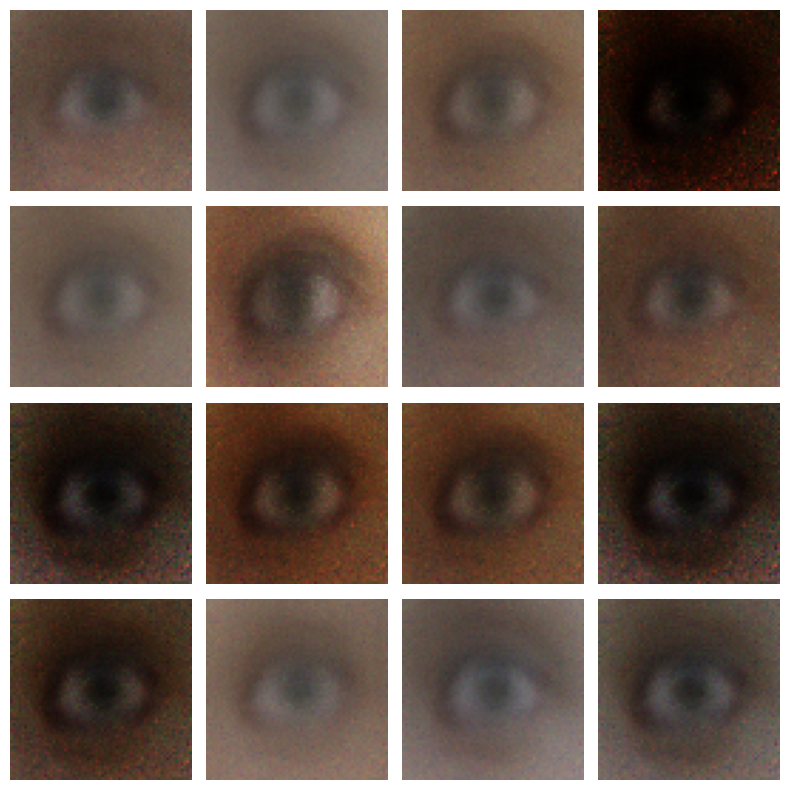

In [11]:
z = torch.randn(16, 100).to(device)
fake_imgs = generator(z).detach().cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_imgs[i].permute(1, 2, 0) * 0.5 + 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()
